In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import time
import json
from IPython.display import Image
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pickle
import os
from collections import Counter
from sklearn.naive_bayes import GaussianNB

## GPS

In [222]:
uid = 'u01'
gps01 = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/gps/gps_{}.csv'.format(uid),index_col=False) 

In [17]:
gps01.head()

,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,time_est,date
0,1364357009,network,wifi,67.993,43.706667,-72.289097,0.000000,0.0,0.00,stationary,2013-03-27 00:03:29,2013-03-27
1,1364358209,network,wifi,23.000,43.706637,-72.289066,0.000000,0.0,0.00,moving,2013-03-27 00:23:29,2013-03-27
2,1364359405,gps,NaN,16.000,43.706678,-72.289018,136.300003,96.2,0.25,NaN,2013-03-27 00:43:25,2013-03-27
3,1364360609,network,wifi,71.126,43.706665,-72.289087,0.000000,0.0,0.00,stationary,2013-03-27 01:03:29,2013-03-27
4,1364361805,gps,NaN,16.000,43.706808,-72.289369,154.500000,0.0,0.00,NaN,2013-03-27 01:23:25,2013-03-27


In [160]:
def moving_time(uid,display = True):
    gps = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/gps/gps_{}.csv'.format(uid),index_col=False) 
    gps['time_est'] = gps['time'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    gps['date'] =  gps['time'].apply(lambda x: datetime.fromtimestamp(x).date())    
    gps['weekday'] = gps['time'].apply(lambda x: datetime.fromtimestamp(x).weekday()) # Monday:0
    gps_daily = pd.DataFrame()
    gps_daily['moving_time'] = gps[gps['travelstate'] == 'moving'].groupby('date')['travelstate'].count()
    gps_daily['weekday'] = gps_daily.index.map(lambda s: s.weekday())
    
    week_num = []
    count = 0 
    for i in gps_daily['weekday']:
        if i == 0:
            count += 1
            week_num.append(count)
        else:
            week_num.append(' ')
 
    if display == True:
        plt.rcdefaults()
        plt.style.use('seaborn-poster')
        fig, ax = plt.subplots()
        fig.canvas.draw()
        ax.plot(gps_daily.index,gps_daily['moving_time'],'-o',color='m',label="moving time")

        ax.set_ylabel('minutes')
        ax.set_title('Moving Time')
        ax.set_xticks(gps_daily.index)
        ax.set_xticklabels(week_num)
        ax.yaxis.grid(True, dash_capstyle='round',linestyle=':')
        
        plt.show()

    return gps_daily

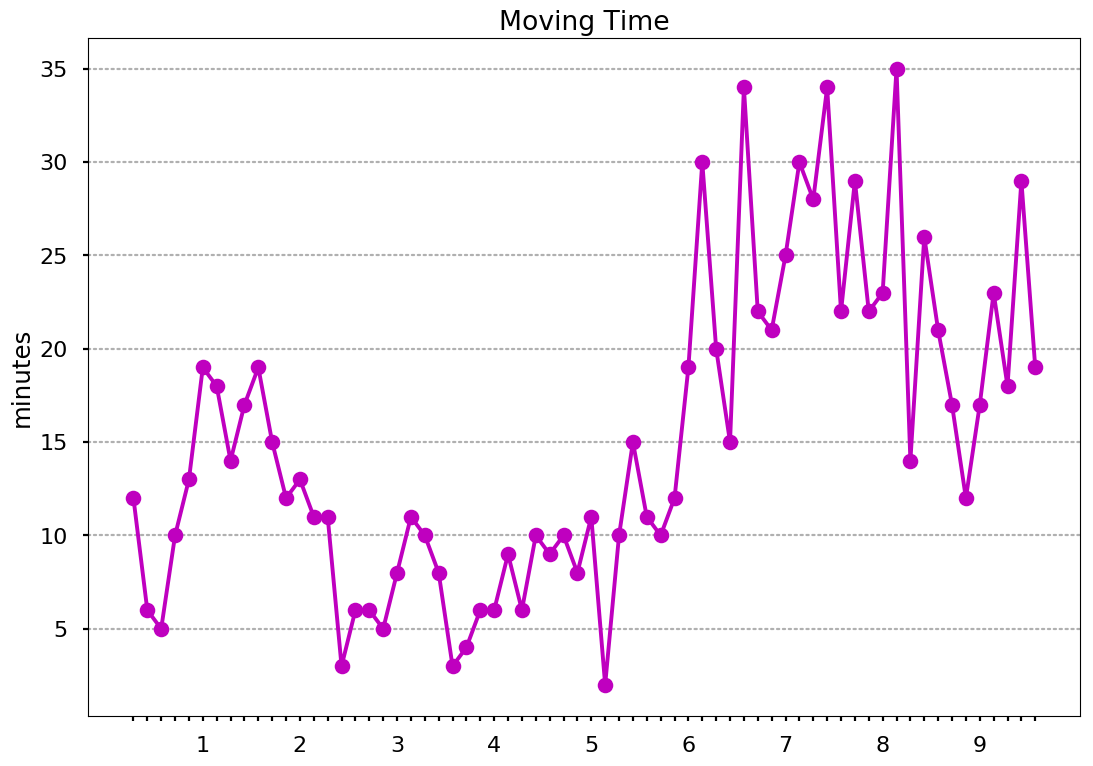

In [161]:
moving_time01 = moving_time('u02')

In [92]:
# student clustering
std = [(0, 2), (1, 2), (2, 2), (3, 0), (4, 2), (5, 2), (6, 1), (7, 0), (8, 0), (9, 2), (10, 2), (11, 1), (12, 1), (13, 0), (14, 0), (15, 1), (16, 0), (17, 0), (18, 0), (19, 2), (20, 0), (21, 2), (22, 2), (23, 0), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 0), (30, 2), (31, 0), (32, 0), (33, 0), (34, 2), (35, 1), (36, 0), (37, 0), (38, 1), (39, 2)]
student_cluster = dict(zip(*zip(*std)))
# real id mapping
real_id_mapping = {0: '00', 1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '07', 7: '09', 8: '10', 9: '14', 10: '15', 11: '16', 12: '17', 13: '18', 14: '19', 15: '20', 16: '23', 17: '24', 18: '27', 19: '30', 20: '31', 21: '32', 22: '33', 23: '34', 24: '35', 25: '36', 26: '42', 27: '43', 28: '44', 29: '45', 30: '47', 31: '49', 32: '51', 33: '52', 34: '53', 35: '56', 36: '58', 37: '59', 38: '46', 39: '54'}
student_cluster = {'u'+str(real_id_mapping[key]):value for key, value in student_cluster.items()}


In [197]:
focus = list(student_cluster.keys())
## moving time feature
def prepare(column = 'moving_time'): 
    uid = 'u00'
    gps = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/gps/gps_{}.csv'.format(uid),index_col=False) 
    gps['date'] =  gps['time'].apply(lambda x: datetime.fromtimestamp(x).date())    
    gps_daily = pd.DataFrame()
    gps_daily['moving_time'] = gps[gps['travelstate'] == 'moving'].groupby('date')['travelstate'].count()
    gps_daily['weekday'] = gps_daily.index.map(lambda s: s.weekday())
  
    gps_daily_merged = gps_daily[[column]]
    
    gps_daily_merged.columns = [column+'_u00']


    for i in focus:
            if i == 'u00':
                continue
            if i in student_cluster:
                gps_daily_i = moving_time(uid = i,display=False)
                gps_daily_merged = gps_daily_merged.merge(gps_daily_i[[column]], left_index=True, right_index=True, how = 'left',suffixes=['','_'+i])

              
    gps_daily_merged = gps_daily_merged.rename(columns = {column:column+'_u01'})
    return gps_daily_merged.transpose() # row: user, column: time stamp

In [198]:
moving_timeall = prepare()

In [239]:
moving_timeall

date,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,...,2013-05-19,2013-05-22,2013-05-23,2013-05-24,2013-05-25,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31
moving_time_u00,22.0,36.0,26.0,1.0,6.0,24.0,15.0,26.0,23.0,23.0,...,1.0,5.0,21.0,17.0,23.0,21.0,33.0,28.0,31.0,38.0
moving_time_u01,16.0,12.0,19.0,14.0,8.0,11.0,18.0,21.0,30.0,22.0,...,21.0,30.0,31.0,4.0,52.0,15.0,17.0,1.0,NaN,NaN
moving_time_u02,12.0,6.0,5.0,10.0,13.0,19.0,18.0,14.0,17.0,19.0,...,22.0,14.0,26.0,21.0,17.0,17.0,23.0,18.0,29.0,19.0
moving_time_u03,9.0,1.0,7.0,NaN,NaN,6.0,NaN,9.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
moving_time_u04,33.0,32.0,43.0,34.0,47.0,33.0,26.0,26.0,33.0,29.0,...,2.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
moving_time_u05,19.0,17.0,20.0,8.0,5.0,21.0,20.0,20.0,19.0,19.0,...,9.0,25.0,15.0,3.0,NaN,16.0,21.0,5.0,NaN,NaN
moving_time_u07,15.0,14.0,13.0,13.0,15.0,23.0,16.0,16.0,21.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
moving_time_u09,17.0,16.0,22.0,NaN,NaN,14.0,12.0,20.0,25.0,17.0,...,29.0,22.0,10.0,NaN,NaN,2.0,20.0,19.0,2.0,5.0
moving_time_u10,NaN,NaN,2.0,16.0,10.0,14.0,16.0,16.0,24.0,18.0,...,19.0,15.0,20.0,14.0,16.0,14.0,22.0,18.0,13.0,2.0
moving_time_u14,15.0,26.0,27.0,22.0,12.0,24.0,23.0,22.0,23.0,26.0,...,2.0,12.0,NaN,7.0,NaN,NaN,5.0,11.0,8.0,NaN


In [102]:
moving_timeall.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/moving_timeall.csv')

In [209]:
gps_all = pd.DataFrame()

In [210]:
gps_all['before_moving'] = moving_timeall[~np.isnan(moving_timeall)].iloc[:,:35].mean(axis=1)

In [211]:
gps_all['after_moving'] = moving_timeall[~np.isnan(moving_timeall)].iloc[:,35:].mean(axis=1)

In [212]:
gps_all = gps_all.reset_index()
gps_all['uid'] = gps_all['index'].apply(lambda x: x.split('_')[2])
gps_all.drop(['index'],inplace=True,axis=1)
gps_all.head()

,before_moving,after_moving,uid
0,16.685714,15.961538,u00
1,16.428571,23.181818,u01
2,9.600000,21.115385,u02
3,5.080000,3.500000,u03
4,27.735294,24.666667,u04


In [216]:
def loc_var(uid):
    gps = pd.read_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/gps/gps_{}.csv'.format(uid),index_col=False) 
    gps['date'] =  gps['time'].apply(lambda x: datetime.fromtimestamp(x).date())    
    gps_daily = pd.DataFrame()
    gps_daily['latitude_var'] = gps[gps['travelstate'] == 'stationary'].groupby('date')['latitude'].var()
    gps_daily['longitude_var'] = gps[gps['travelstate'] == 'stationary'].groupby('date')['longitude'].var()
    gps_daily['weekday'] = gps_daily.index.map(lambda s: s.weekday())
    gps_daily['loc_var'] = np.log(gps_daily['latitude_var']+gps_daily['longitude_var']+0.1)
    
    weekend= gps_daily[gps_daily['weekday'].isin([5,6])]['loc_var'].mean()
    weekday=gps_daily[~gps_daily['weekday'].isin([5,6])]['loc_var'].mean()
    return weekend,weekday
    

In [217]:
## location variance feature
def prepare_loc_var(column = 'loc_var'): 
    weekend,weekday = loc_var('u00')     
    df = pd.DataFrame([['u00',weekend,weekday]], columns=['uid','weekend_locvar','weekday_locvar'])


    for ind in range(len(focus)):
        i = focus[ind]
        if i == 'u00':
            continue
        if i in student_cluster:
            weekend_i,weekday_i = loc_var(i)
            df.loc[ind,'uid'] = i
            df.loc[ind,'weekend_locvar'] = weekend_i
            df.loc[ind,'weekday_locvar'] = weekday_i
            
                 
    return df 

In [218]:
location_variance = prepare_loc_var()

In [221]:
gps_all = location_variance.merge(gps_all,left_on='uid',right_on = 'uid',how='outer')

In [237]:
gps_all.head()

,uid,weekend_locvar,weekday_locvar,before_moving,after_moving
0,u00,-1.734485,-2.162183,16.685714,15.961538
1,u01,-2.302554,-2.302559,16.428571,23.181818
2,u02,-2.286666,-2.300463,9.600000,21.115385
3,u03,-2.302580,-2.302579,5.080000,3.500000
4,u04,-2.302508,-2.302410,27.735294,24.666667


In [238]:
gps_all.to_csv('/Users/Mengying/Desktop/DataMining/Project/dataset/dataset/sensing/mydata/gps_all.csv',index=False)